[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Maskology/machine-learning-notebook/blob/main/balinese_mask_classifier.ipynb)

# Preparation

## Import

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import humanize
import random
import re
import shutil
import math
import multiprocessing
import asyncio
import concurrent.futures

from google.colab import files
from PIL import Image
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

## Dataset Note
- Please zip the dataset
- Use Folder structure like below (e.g. **balinese mask** as dataset directory and directory inside it as **labels**)<br>
![Screenshot from 2022-05-19 23-44-24.png](https://i.ibb.co/SPj29Dd/Screenshot-from-2022-05-19-23-44-24.png)

# Settings

## Path

In [2]:
# Kaggle 
KAGGLE_DATASET_PATH = 'suryapradana/balinese-mask'

# Zipped
ZIP_DATASET = 'balinese-mask.zip'

# Unzipped
DATASET_DIR = 'balinese mask'
DATASET_PATH = os.path.join(os.getcwd(), DATASET_DIR)

# Compressed
COMPRESSED_DATASET_DIR = 'compressed_dataset'
COMPRESSED_DATASET_PATH = os.path.join(os.getcwd(), COMPRESSED_DATASET_DIR)

# Split Distribution
STRUCTURED_COMPRESSED_DATASET_PATH = os.path.join(os.getcwd(), 'structured_compressed_dataset')
STRUCTURED_DATASET_PATH = os.path.join(os.getcwd(), 'structured_dataset')

# Export
EXPORT_MODEL_JS_DIR = os.path.join(os.getcwd(), 'exported_tfjs')
EXPORT_MODEL_TFLITE_PATH = os.path.join(os.getcwd(), 'exported_tflite/model.tflite')
EXPORT_MODEL_SAVED_DIR = os.path.join(os.getcwd(), 'exported_saved_model')
EXPORT_MODEL_H5 = os.path.join(os.getcwd(), 'exported_h5/model.h5')

## Config

In [3]:
# Kaggle
KAGGLE_KEY = 'other_key' #@param ["my_key", "other_key"]

# Compress Image Settings 
COMPRESS_QUALITY_PERCENT = 20  #@param {type:"slider", min:1, max:100, step:1}
COMPRESS_SAMPLE = 2  #@param {type:"slider", min:1, max:4, step:1}
COMPRESS_OVERWRITE_EXISTS = False #@param {type:"boolean"}
COMPRESS_IMG_SIZE = (500, 500)

# Split dataset settings
SPLIT_OVERWRITE_EXIST = False #@param {type:"boolean"}
TRAINING_SPLIT_PERCENT = 60 #@param {type:"slider", min:60, max:90, step:5}
TRAINING_SPLIT = TRAINING_SPLIT_PERCENT / 100 
VALIDATION_SPLIT_PERCENT = 20 #@param {type:"slider", min:10, max:40, step:5}
VALIDATION_SPLIT = VALIDATION_SPLIT_PERCENT / 100

# Image data generator settings
IMG_SIZE = (280, 280) 
BATCH_SIZE = 32 #@param {type:"slider", min:5, max:64, step:1}
DATASET_TYPE = 'compressed' #@param ["original", "compressed"]

EPOCHS = 30 #@param {type:"slider", min:5, max:50, step:5}
MODEL_TYPE = 'transfer_learning_vgg16' #@param ["manual", "transfer_learning_vgg16"]

SHOW_FEATURE_MAP = False #@param {type:"boolean"}

EXPORT_TO_JS = True #@param {type:"boolean"}
EXPORT_TO_TFLITE = False #@param {type:"boolean"}
EXPORT_TO_SAVED_MODEL = False #@param {type:"boolean"}
EXPORT_TO_H5 = False #@param {type:"boolean"}

TEST_REAL_DATA = False #@param {type:"boolean"}


## Assert Config

In [4]:
# Assert Split Dataset Settings
train_val_split = TRAINING_SPLIT_PERCENT + VALIDATION_SPLIT_PERCENT
test_split_percent = 100 - train_val_split
assert test_split_percent >= 0, "Should provide for test split"
assert train_val_split <= 100, "Invalid split"
print(f'Dataset Split: Train {TRAINING_SPLIT_PERCENT}%, Validation {VALIDATION_SPLIT_PERCENT}%, Test {test_split_percent}%')

Dataset Split: Train 60%, Validation 20%, Test 20%


# Utility

## Directory and File

In [5]:
def remove_existing_dir(dir):
    if os.path.exists(dir) and os.path.isdir(dir):
        shutil.rmtree(dir)
def remove_existing_file(path):
    if os.path.exists(path) and os.path.isfile(path):
        os.remove(path)

def create_dir_if_not_exists(dir):
    if not os.path.exists(dir):
        os.makedirs(dir, exist_ok=True)

def get_file_size(path):
    return humanize.naturalsize(os.path.getsize(path))

def copy(src, dst):
    filename = os.path.basename(dst)
    remove_existing_dir(dst)
    remove_existing_file(dst)
    create_dir_if_not_exists(re.sub(filename, '', dst))

    if os.path.isdir(src):
        shutil.copytree(src, dst)
    elif os.path.isfile(src):
        shutil.copy(src, dst)
    else:
        print(f'{src} is neither directory nor file')

def get_nested_file_path(dir):
    paths = []
    for root, dirs, files in os.walk(dir):
     for file in files:
        path = os.path.join(root, file)
        paths.append(path)
    return paths

def count_files_in_dir(dir):
    return sum(len(files) for _, _, files in os.walk(dir))

## Image

In [6]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(path=img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    return array

## CNN

In [7]:
def get_cnn_last_conv_layer_name(model: tf.keras.models.Model):
    conv_layers = get_cnn_conv_layers(model)
    assert len(conv_layers) > 0, "model doesn't have conv2d layer"
    return conv_layers[-1].name

def get_cnn_conv_layers(model: tf.keras.models.Model):
    return list(filter(lambda x: isinstance(x, Conv2D), model.layers))

## Grad-CAM

In [8]:
def get_gradcam_superimposed_image_from_path(img_path, img_size, model: tf.keras.models.Model):
    img_array = get_img_array(img_path, img_size)
    heatmap = get_gradcam_heatmap(img_array/255.0, model)
    superimposed_img = get_gradcam_superimosed_img(img_array, heatmap)
    return superimposed_img

def get_gradcam_heatmap(img_array, model: tf.keras.models.Model, pred_index=None):
    last_conv_layer_name = get_cnn_last_conv_layer_name(model)

    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam_superimosed_img(img_array, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Download Dataset

## Kaggle Key
**NOTE**: This setting need to load kaggle API Token from google drive

Please create Kaggle API Token, and then copy to `keys/kaggle.json` in your google drive

Make Sure to mount your google drive 

[See this tutorial](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)


In [9]:
!mkdir -p ~/.kaggle

In [10]:
path = '~/.kaggle/kaggle.json' 

# IF you select 'my_key' in $KAGGLE_KEY settings
# Please Mount Your google drive first
# Make create Kaggle API Token
# Then copy to /keys/kaggle.json in your google drive 
my_key_cmd = f'cp /content/drive/MyDrive/keys/kaggle.json {path}'

# Else use others key that available on github
# You can find kaggle.json on github :v
other_keys = [
  'https://raw.githubusercontent.com/Harsha470/my_kaggle_json/main/kaggle.json'
]
other_key_cmd = f'curl {random.choice(other_keys)} > {path}'

# Run
cmd = {
    'my_key': my_key_cmd,
    'other_key': other_key_cmd 
}
os.system(cmd[KAGGLE_KEY])
os.system(f'chmod 600 {path}')

0

## Kaggle Download

In [11]:
# Download Dataset From Kaggle
!kaggle datasets download -d $KAGGLE_DATASET_PATH

 99% 0.99G/0.99G [00:08<00:00, 109MB/s]
100% 0.99G/0.99G [00:08<00:00, 132MB/s]


## Unzip

In [12]:
!unzip -q -n $ZIP_DATASET

## Visualize Dataset Count

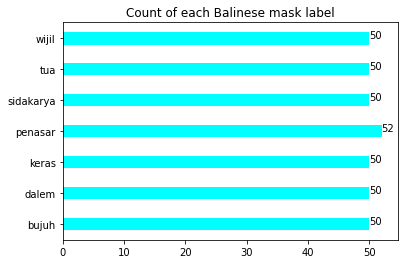

In [13]:
LABELS = sorted(os.listdir(DATASET_PATH))

def visualize_dataset_count(dir, title, figsize=(6, 4), color='cyan', bar_width=.4):
    data = count_files_each_label(dir)
    labels = list(data.keys())
    values = list(data.values())
    
    fig = plt.figure(figsize=figsize)
    plt.barh(labels, values, color=color, height=bar_width)
    for i, value in enumerate(values):
        plt.text(value, i, str(value))
    plt.title(title)
    plt.show()


def count_files_each_label(dir):
    result = {}
    labels = sorted(os.listdir(dir))
    for label in labels:
        count = count_files_in_dir(os.path.join(dir, label))
        result[label] = count
    return result

visualize_dataset_count(DATASET_PATH, title='Count of each Balinese mask label')

# Compress Dataset


## Define Class


In [14]:
class CompressImgDataset():
    
    def __init__(
        self, 
        src_dir, 
        dst_dir,
        img_size=(128, 128),
        quality=10,
        overwrite_exists=False,
        limit_file=None
    ):
        self.src_dir = src_dir
        self.dst_dir = dst_dir

        self.img_size = img_size
        self.limit_file = limit_file
        self.quality = quality
        self.overwrite_exists = overwrite_exists
        
        self.result_paths = []
        self.set_result_paths()

    def compress(self):
        if os.path.exists(self.dst_dir) and not self.overwrite_exists:
            print('Compressed dataset already exists!')
            return
        remove_existing_dir(self.dst_dir)
        self.compress_concurrency()

    def compress_concurrency(self):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(lambda args: self.compress_img(*args), self.result_paths)

    def compress_parallel(self):
        with multiprocessing.Pool() as pool:
            pool.starmap(self.compress_img, self.result_paths)
    
    def compress_img(self, src_path, dst_path):
        filename = os.path.basename(dst_path)
        dst_dir = re.sub(filename, '', dst_path)
        create_dir_if_not_exists(dst_dir)
        remove_existing_file(dst_path)
        img = Image.open(src_path)
        img.thumbnail(self.img_size, Image.ANTIALIAS)
        img.save(dst_path, quality=self.quality, optimize=True)

    def set_result_paths(self):
        for path, subdirs, files in os.walk(self.src_dir):
            for name in files:
                if isinstance(self.limit_file, int) and len(self.result_paths) >= self.limit_file:
                    break
                src_path = os.path.join(path, name)
                dst_path = re.sub(self.src_dir, self.dst_dir, src_path)
                self.result_paths.append((src_path, dst_path))

    def show_result_samples(self, n=2, figsize=None, axis='on'):
        samples = random.sample(self.result_paths, n)
        fig, axes = plt.subplots(len(samples), 2, figsize=figsize, constrained_layout=True)
        for i, sample in enumerate(samples):
            original, compressed = sample
            sample = ((original, 'Original'), (compressed, 'Compressed'))
            for j, data in enumerate(sample):
                path, kind = data
                img = Image.open(path)
                ax = axes[i][j] 
                ax.imshow(img)
                ax.set_title(f'{kind} {get_file_size(path)}')
                ax.set_xlabel(img.size)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.axis(axis)
        plt.show()

## Experiment with sample dataset

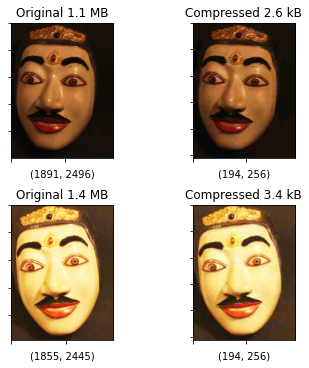

In [15]:
n = 2
tmp = 'tmp'
c = CompressImgDataset(
    src_dir=DATASET_PATH, 
    dst_dir=tmp,
    quality=20,
    overwrite_exists=True,
    limit_file=n,
    img_size=(256,256)
)
c.compress()
c.show_result_samples(n=n, figsize=(5, 5), axis='on')

!rm -rf $tmp

## Compress The Dataset

In [16]:
cid = CompressImgDataset(
    src_dir=DATASET_PATH, 
    dst_dir=COMPRESSED_DATASET_PATH,
    img_size=COMPRESS_IMG_SIZE,
    quality=COMPRESS_QUALITY_PERCENT,
    overwrite_exists=COMPRESS_OVERWRITE_EXISTS
)
cid.compress()

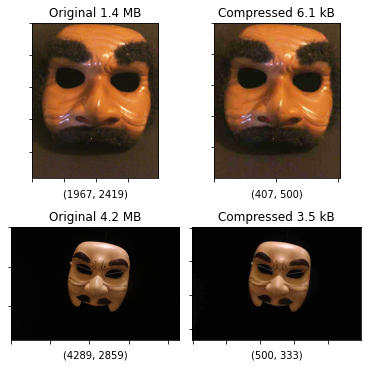

In [17]:
cid.show_result_samples(n=COMPRESS_SAMPLE, figsize=(5, 5))

## Show image of each label

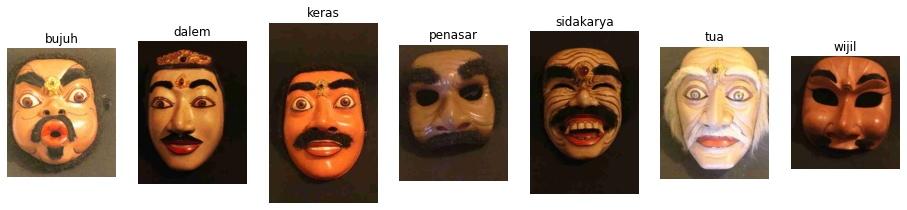

In [18]:
def show_image_from_each_dir_label(dir, ncols=4, figsize=None, shuffle=True):
    # Getting first file of each label
    paths = [] 
    labels = sorted(os.listdir(dir))
    for label in labels:
        label_dir = os.path.join(dir, label)
        files = os.listdir(label_dir)
        if shuffle:
            random.shuffle(files)
        for f in files:
            file_path = os.path.join(label_dir,f)
            if os.path.isfile(file_path):
                paths.append((file_path, label))
                break

    # Plott images
    nrows = math.ceil(len(paths)/ncols)
    plt.figure(figsize=figsize)
    for i, data in enumerate(paths):
        path, label = data
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(Image.open(path))
        plt.title(label)
        plt.axis('off')
    plt.show()

show_image_from_each_dir_label(COMPRESSED_DATASET_PATH, ncols=len(LABELS), figsize=(16, 5))

## Zip Dataset

In [19]:
!zip -q -r {COMPRESSED_DATASET_PATH}.zip $COMPRESSED_DATASET_PATH
zip_size_before = get_file_size(ZIP_DATASET)
zip_size_after = get_file_size(f'{COMPRESSED_DATASET_PATH}.zip')
print(f'Original {zip_size_before}, Compressed {zip_size_after}')

Original 1.1 GB, Compressed 2.0 MB


# Split Dataset Distribution

## Define Class

In [20]:
class DatasetDirectoryLabelSplit():

    def __init__(
        self, 
        src_dir, 
        dst_dir, 
        train_split=.8, 
        validation_split=None,
        shuffle=True,
        overwrite_exists=False,
    ):
        self.src_dir = src_dir
        self.dst_dir = dst_dir

        self.train_split = train_split
        self.validation_split = validation_split
        self.shuffle = shuffle

        self.train_n = 0
        self.validation_n = 0
        self.test_n = 0

        self.label_distribution = []
        self.set_label_distribution()

        self.overwrite_exists = overwrite_exists

        self.distribution_path = {}
        self.copy_paths = []
        self.set_copy_paths()

    def create(self):
        if os.path.exists(self.dst_dir) and not self.overwrite_exists:
            print('Split folder already exists!')
            return
        remove_existing_dir(self.dst_dir)
        self.create_concurrency()

    def create_concurrency(self):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(lambda args: copy(*args), self.copy_paths)

    def create_parallel(self):
        with multiprocessing.Pool() as pool:
            pool.starmap(copy, self.copy_paths)

    def set_copy_paths(self):
        for data in self.label_distribution:        
            for dist, files in data['dist'].items():
                dist_dir = os.path.join(self.dst_dir, dist)
                self.distribution_path[dist] = dist_dir
                for f in files:
                    src_file = os.path.join(self.src_dir, data['label'], f)
                    dst_file = os.path.join(dist_dir, data['label'], f)
                    self.copy_paths.append((src_file, dst_file))

    def set_label_distribution(self):
        labels = os.listdir(self.src_dir)
        for label in labels:
            files = os.listdir(os.path.join(self.src_dir, label))
            if self.shuffle:
                random.shuffle(files)
            train_n, val_n, test_n, = self.get_num_train_val_test_split(
                len(files),
                self.train_split,
                self.validation_split
            )
            self.train_n += train_n
            self.validation_n += val_n
            self.test_n += test_n
            self.label_distribution.append({
                'label': label,
                'dist': {
                    # 'all': files,
                    'train': files[:train_n],
                    'validation': files[train_n:train_n+val_n],
                    'test': files[-test_n:]
                }
            })

    def get_num_train_val_test_split(self, n, train_split, validation_split=None):
        train_n = round(n * train_split)
        rest = n - train_n
        val_n = round(n * validation_split) if validation_split else round(rest / 2)
        test_n = rest - val_n
        return train_n, val_n, test_n
    

## Split original dataset

In [21]:
split = DatasetDirectoryLabelSplit(
    src_dir=DATASET_PATH, 
    dst_dir=STRUCTURED_DATASET_PATH,
    train_split=TRAINING_SPLIT,
    validation_split=VALIDATION_SPLIT,
    overwrite_exists=SPLIT_OVERWRITE_EXIST,
)
split.create()
dataset_distribution_path = split.distribution_path
dataset_distribution_path

{'test': '/content/structured_dataset/test',
 'train': '/content/structured_dataset/train',
 'validation': '/content/structured_dataset/validation'}

## Split compressed dataset

In [22]:
compressed_split = DatasetDirectoryLabelSplit(
    src_dir=COMPRESSED_DATASET_PATH, 
    dst_dir=STRUCTURED_COMPRESSED_DATASET_PATH,
    train_split=TRAINING_SPLIT,
    validation_split=VALIDATION_SPLIT,
    overwrite_exists=SPLIT_OVERWRITE_EXIST,
)
compressed_split.create()
dataset_distribution_compressed_path = compressed_split.distribution_path
dataset_distribution_compressed_path

{'test': '/content/structured_compressed_dataset/test',
 'train': '/content/structured_compressed_dataset/train',
 'validation': '/content/structured_compressed_dataset/validation'}

# Image generator

## Define Function

In [23]:
DEFAULT_IMG_SIZE = (64, 64)
DEFAULT_RESCALE = 1 / 255.0
DEFAULT_CLASS_MODE = 'categorical'
DEFAULT_BATCH_SIZE = 32

DEFAULT_FIGSIZE = None
DEFAULT_SHOW_SIZE = 3


DEFAULT_TRAIN_GEN_PARAMS = {
    'rescale': DEFAULT_RESCALE,
    'horizontal_flip': True,
    'rotation_range': 45,
    'width_shift_range': .3,
    'height_shift_range': .3,
    'shear_range': .2,
    'zoom_range': .3,
}
DEFAULT_VAL_GEN_PARAMS = {
    'rescale': DEFAULT_RESCALE,
}
DEFAULT_TEST_GEN_PARAMS = {
    'rescale': DEFAULT_RESCALE,
}


def get_image_dataset_generator_from_path(
    train_path, 
    validation_path, 
    test_path, 
    
    img_size=DEFAULT_IMG_SIZE,
    class_mode=DEFAULT_CLASS_MODE,
    batch_size=DEFAULT_BATCH_SIZE,

    train_gen_params=DEFAULT_TRAIN_GEN_PARAMS,
    val_gen_params=DEFAULT_VAL_GEN_PARAMS,
    test_gen_params=DEFAULT_TEST_GEN_PARAMS
):
    ds_params = {
        'batch_size': batch_size,
        'target_size': img_size,
        'class_mode': class_mode,
    }

    train_gen = ImageDataGenerator(**train_gen_params)
    train_ds = train_gen.flow_from_directory(train_path, **ds_params, shuffle=True)

    validation_gen = ImageDataGenerator(**val_gen_params)
    validation_ds = validation_gen.flow_from_directory(validation_path, **ds_params, shuffle=False)

    test_gen = ImageDataGenerator(**test_gen_params)
    test_ds = test_gen.flow_from_directory(test_path, **ds_params, shuffle=False)

    return train_ds, validation_ds, test_ds

def show_dataset_images(dataset, ncols=8, n=8*2, figsize=(16, 4)):
    labels = list(dataset.class_indices.keys())
    nrows = math.ceil(n/ncols)
    plt.figure(figsize=figsize)
    for i in range(n):
        img, label = dataset.next()
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img[0])
        plt.title(labels[np.argmax(label)])
        plt.axis('off')
    plt.show()


## Image generator dataset

In [24]:
dataset_dist = dataset_distribution_compressed_path if DATASET_TYPE == 'compressed' else dataset_distribution_path

train_ds, validation_ds, test_ds = get_image_dataset_generator_from_path(
    train_path=dataset_dist['train'],
    validation_path=dataset_dist['validation'],
    test_path=dataset_dist['test'],
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 212 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 70 images belonging to 7 classes.



Train images


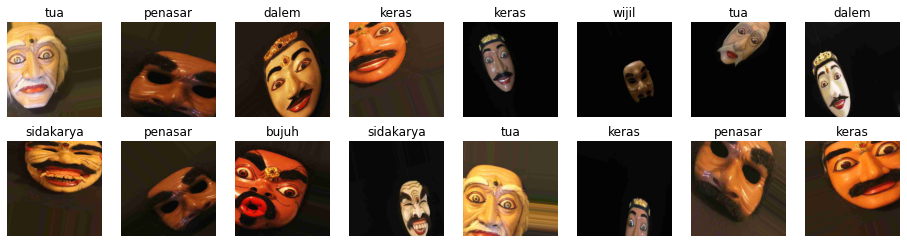


Validation images


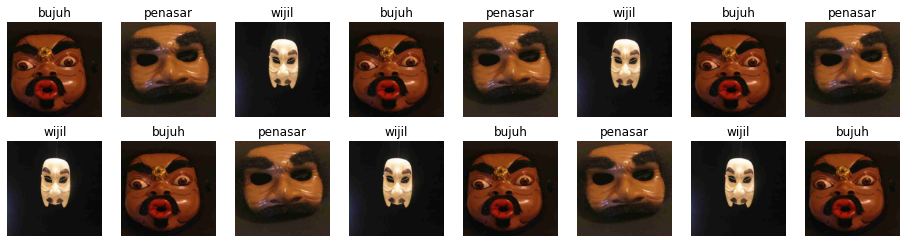

In [25]:
ncols = 8
n = ncols * 2
figsize = (16,4)

print('\nTrain images')
show_dataset_images(dataset=train_ds, ncols=ncols, n=n, figsize=figsize)

print('\nValidation images')
show_dataset_images(dataset=validation_ds, ncols=ncols, n=n, figsize=figsize)

# Model




## Models

In [26]:
class ModelInterface:
    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units
        self.model = self.get_model()
        self.compile_params = self.get_compile_params()
        self.callbacks = self.get_callbacks()

    def get_model(self):
        raise NotImplementedError

    def get_compile_params(self):
        raise NotImplementedError

    def get_callbacks(self):
        return None

In [27]:
class ModelManual(ModelInterface):
    
    def get_model(self):
        return Sequential([
            Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu, input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2,2)),

            Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
            MaxPooling2D(pool_size=(2,2)),

            Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
            MaxPooling2D(pool_size=(2,2)),
            
            Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
            MaxPooling2D(pool_size=(2,2)),
            
            Dropout(rate=.2),

            Flatten(),
            Dense(units=512, activation=tf.nn.relu),
            Dense(units=self.output_units, activation=tf.nn.softmax),
        ])

    def get_compile_params(self):
        return {
            'loss': tf.losses.CategoricalCrossentropy(), 
            'optimizer': tf.optimizers.Adam(), 
            'metrics':["accuracy"]
        }

    def get_callbacks(self):
        return [
            EarlyStopping(monitor='val_loss', patience=5)
        ]

In [28]:
from keras.applications.vgg16 import VGG16

FINE_TUNING = 2

class ModelTransferVGG16(ModelInterface):

    fine_tune: int = FINE_TUNING

    def get_model(self):
        base = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        if self.fine_tune is not None:
            for layer in base.layers[:-self.fine_tune]:
                layer.trainable = False
        else:  
            base.trainable = False
        
        # # Sequential
        # # WARNING: If you want to use sequential, please find way to prevent nested layer 
        # return Sequential([
        #     base,
        #     Flatten(),
        #     Dense(units=self.output_units, activation=tf.nn.softmax),
        # ])

        # Functional 
        x = base.output
        x = Flatten()(x)
        x = Dense(units=512, activation=tf.nn.relu)(x)
        x = Dense(units=256, activation=tf.nn.relu)(x)
        x = Dropout(rate=.2)(x)
        output_layer = Dense(units=self.output_units, activation=tf.nn.softmax)(x)
        return Model(inputs=base.input, outputs=output_layer)

    def get_compile_params(self):
        return {
            'loss': tf.losses.CategoricalCrossentropy(), 
            # 'optimizer': tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9), 
            'optimizer': tf.optimizers.Adam(),
            'metrics':["accuracy"]
        }

    def get_callbacks(self):
        return [
            # EarlyStopping(monitor='val_loss', patience=3),
            EarlyStopping(
                monitor='val_accuracy', 
                mode='max', 
                patience=5,  
                restore_best_weights=True
            )  
        ]

In [29]:
model_options = {
    'manual': ModelManual,
    'transfer_learning_vgg16': ModelTransferVGG16
}

## Wrapper

In [30]:
DEFAULT_EPOCHS = 15
DEFAULT_TRAIN_VERBOSE = 1
DEFAULT_FIGSIZE = None

class ModelWrapper:
    def __init__(
        self, 
        train_ds: tf.keras.preprocessing.image.DirectoryIterator,
        validation_ds: tf.keras.preprocessing.image.DirectoryIterator,
        test_ds: tf.keras.preprocessing.image.DirectoryIterator, 
        model: ModelInterface,
        epochs=DEFAULT_EPOCHS,
        saved_model_dir=os.path.join(os.getcwd(), 'saved_model'),
    ):
        # Data 
        self.train_ds = train_ds
        self.validation_ds = validation_ds,
        self.test_ds = test_ds
        self.labels = self.get_labels_from_dataset()
        
        # Saved Model
        self.saved_model_dir = saved_model_dir
        
        # Model Configuration
        self.input_shape = self.get_input_shape_from_dataset()
        self.output_units = len(self.labels)
        model = model(self.input_shape, self.output_units)
        self.model = model.model
        self.compile_params = model.compile_params

        # Training
        self.training = None
        self.epochs = epochs
        self.callbacks  = model.callbacks if model.callbacks else self.get_default_callbacks()

        self.model.summary(expand_nested=True)

    def compile(self):
        self.model.compile(**self.compile_params)

    def train(self, verbose=DEFAULT_TRAIN_VERBOSE):
        self.training = self.model.fit(
            x=self.train_ds,
            validation_data=self.validation_ds,
            epochs=self.epochs,
            verbose=verbose,
            callbacks=self.callbacks,
        )

    def evaluate(self):
        return self.model.evaluate(self.test_ds)

    def test_upload_images(self, show_image=False):
        uploaded = files.upload()
        paths = uploaded.keys()
        print()

        for i, path in enumerate(paths):
            img = image.load_img(path, target_size=self.input_shape[:-1])
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])
            label = self.labels[np.argmax(self.model.predict(images))]
            msg = f'{path} Predicted as {label}'
        
            if show_image:
                plt.subplot(len(paths), 1, i+1)
                plt.imshow(img)
                plt.title(msg)
                plt.axis('off')
            else:
                print(msg)
        
            os.remove(path)

    def show_metrics_per_epochs(
        self, 
        metric_title='Accuracy per epochs', 
        metric_name='accuracy',
        metrics=['accuracy', 'val_accuracy'],
        figsize=DEFAULT_FIGSIZE
    ):
        plt.figure(figsize=figsize)
        for metric in metrics:
            plt.plot(self.training.history[metric], label=metric)
        plt.title(metric_title)
        plt.xlabel('epochs')
        plt.ylabel(metric_name)
        plt.legend()
        plt.show()
    
    def show_confusion_matrix(self, dataset, scaled=True, figsize=None, hline=True, hline_color='#f00'):
        labels = list(dataset.class_indices.keys())
        y_pred = self.model.predict(dataset)
        y_pred = np.argmax(y_pred, axis=1)
        
        cf_matrix = tf.math.confusion_matrix(dataset.classes, y_pred)
        cf_matrix = cf_matrix/np.sum(cf_matrix, axis=1) if scaled else cf_matrix

        plt.figure(figsize=figsize)
        if hline:
            for i in range(1, len(labels)):
                plt.axhline(y=i, linewidth=1, color=hline_color)

        heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
        heatmap.set_xlabel('\nPredicted')
        heatmap.set_ylabel('Actual');
        heatmap.xaxis.set_ticklabels(labels)
        heatmap.yaxis.set_ticklabels(labels)
        plt.show()

    def get_classification_report(self, dataset):
        labels = list(dataset.class_indices.keys())
        y_pred = self.model.predict(dataset)
        y_pred = np.argmax(y_pred, axis=1)
        return classification_report(y_true=dataset.classes, y_pred=y_pred, target_names=labels)

    def export_to_tfjs(self, dir='tfjs'):
        def convert():
            remove_existing_dir(dir)
            create_dir_if_not_exists(dir)
            cmd = f'tensorflowjs_converter --input_format=tf_saved_model {self.saved_model_dir} {dir}'
            os.system(cmd)
        self.saved_model_wrapper(convert)

    def export_to_tflite(self, path='model.tflite'):
        def convert():
            filename = os.path.basename(path)
            dir = re.sub(filename, '', path)
            create_dir_if_not_exists(dir)
            converter = tf.lite.TFLiteConverter.from_saved_model(self.saved_model_dir)
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS 
            ]
            tflite_model = converter.convert()
            with open(path, 'wb') as f:
                f.write(tflite_model)
        self.saved_model_wrapper(convert)
        
    def saved_model_wrapper(self, export_func):
        self.saved_model(self.saved_model_dir)
        export_func()
        shutil.rmtree(self.saved_model_dir)

    def export_to_h5(self, path='model.h5'):
        self.model.save(path)

    def saved_model(self, dir):
        tf.saved_model.save(self.model, dir)

    def get_default_callbacks(self):
        return [
            EarlyStopping(monitor='val_loss', patience=3),
        ]

    def get_input_shape_from_dataset(self):
        first_batch = self.train_ds.next()[0]
        first_img = first_batch[0]
        return tuple(tf.shape(first_img).numpy())

    def get_labels_from_dataset(self):
        return list(self.train_ds.class_indices.keys())

## Use Model

### Initialize

In [31]:
cnn = ModelWrapper(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds, 
    model=model_options[MODEL_TYPE],
    epochs=EPOCHS
)
cnn.compile()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                              

### Training model

In [32]:
cnn.train()

Epoch 1/30
7/7 [==============================] - 25s 1s/step - loss: 3.9581 - accuracy: 0.1934 - val_loss: 1.6818 - val_accuracy: 0.2143
Epoch 2/30
7/7 [==============================] - 5s 733ms/step - loss: 1.4167 - accuracy: 0.5094 - val_loss: 0.3713 - val_accuracy: 0.9714
Epoch 3/30
7/7 [==============================] - 5s 752ms/step - loss: 0.6833 - accuracy: 0.7453 - val_loss: 0.2794 - val_accuracy: 0.8714
Epoch 4/30
7/7 [==============================] - 5s 711ms/step - loss: 0.5498 - accuracy: 0.7830 - val_loss: 0.1319 - val_accuracy: 0.9714
Epoch 5/30
7/7 [==============================] - 5s 722ms/step - loss: 0.3218 - accuracy: 0.8679 - val_loss: 0.0521 - val_accuracy: 0.9857
Epoch 6/30
7/7 [==============================] - 5s 812ms/step - loss: 0.2444 - accuracy: 0.9198 - val_loss: 0.1105 - val_accuracy: 0.9429
Epoch 7/30
7/7 [==============================] - 5s 708ms/step - loss: 0.2246 - accuracy: 0.9245 - val_loss: 0.0164 - val_accuracy: 0.9857
Epoch 8/30
7/7 [======

### Visualize Training metrics

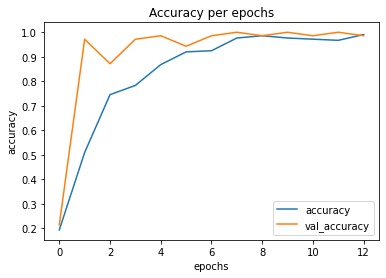

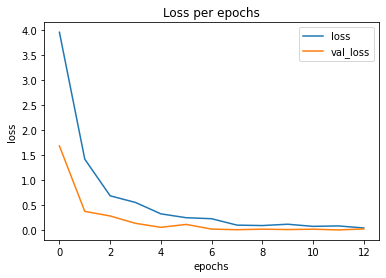

In [33]:
cnn.show_metrics_per_epochs(
    metric_title='Accuracy per epochs', 
    metric_name='accuracy', 
    metrics=['accuracy', 'val_accuracy']
)
print()
cnn.show_metrics_per_epochs(
    metric_title='Loss per epochs',
    metric_name='loss',
    metrics=['loss', 'val_loss']
)

### Evaluate model

In [34]:
cnn.evaluate()

3/3 [==============================] - 1s 149ms/step - loss: 0.0372 - accuracy: 1.0000


[0.037174124270677567, 1.0]

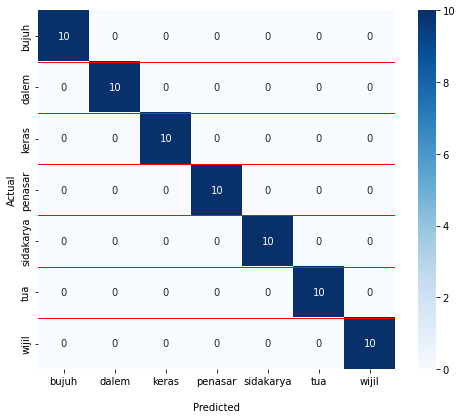

In [35]:
cnn.show_confusion_matrix(dataset=cnn.test_ds, scaled=False, figsize=(8, 6.6))

In [36]:
print(cnn.get_classification_report(dataset=cnn.test_ds))

              precision    recall  f1-score   support

       bujuh       1.00      1.00      1.00        10
       dalem       1.00      1.00      1.00        10
       keras       1.00      1.00      1.00        10
     penasar       1.00      1.00      1.00        10
   sidakarya       1.00      1.00      1.00        10
         tua       1.00      1.00      1.00        10
       wijil       1.00      1.00      1.00        10

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



## Explain Model

### Feature Map

In [37]:
def show_img_freature_map(img_path: str, wrapper: ModelWrapper, ncols:int=2**4, cmap='viridis'):
    img_array = get_img_array(img_path=img_path, size=wrapper.input_shape[:-1])
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array/255.0

    conv_layers = get_cnn_conv_layers(wrapper.model)
    outputs = [layer.output for layer in conv_layers]
    layer_names = [layer.name for layer in conv_layers]

    model = tf.keras.models.Model(inputs=cnn.model.inputs, outputs=outputs)
    feature_maps = model.predict(img_array)

    for i, (layer_name, fmap) in enumerate(zip(layer_names, feature_maps)):
        print(f'\nlayer {layer_name} with {fmap.shape[-1]} filters, layer {i+1} of {len(feature_maps)}')

        nrows = math.ceil(fmap.shape[-1]/ncols)
        plt.figure(figsize=(ncols, nrows))
        for i in range(fmap.shape[-1]):
            plt.subplot(nrows, ncols, i+1)
            plt.axis('off')
            plt.imshow(fmap[0, :, :, i], aspect='auto', cmap=cmap) # cmap=gray|viridis
        plt.show()

In [38]:
if SHOW_FEATURE_MAP:
    paths = get_nested_file_path(STRUCTURED_COMPRESSED_DATASET_PATH)
    img_path = random.choice(paths)
    show_img_freature_map(img_path=img_path, wrapper=cnn)

### Grad-CAM

In [39]:
def show_gradcam_images_from_model_wrapper(
    dataset_dir, 
    wrapper: ModelWrapper, 
    single_label=False,
    custom_label=None,
    figsize=(16,16),
    n=25,
    ncols=5,
):
    paths = get_nested_file_path(dataset_dir) 
    if single_label:
        labels = wrapper.labels
        label = custom_label if custom_label is not None and custom_label in labels else random.choice(labels)
        paths = [x for x in paths if label in x]
        print(f'Grad-CAM {label}')
    else:
        print('Grad-CAM from random images')

    n = n if n < len(paths) else len(paths)
    sample = random.sample(paths, n)

    plt.figure(figsize=figsize)
    nrows = math.ceil(len(sample)/ncols)
    for i, path in enumerate(sample):
        img = get_gradcam_superimposed_image_from_path(
            img_path=path, 
            img_size=wrapper.input_shape[:-1], 
            model=cnn.model
        )
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

Grad-CAM bujuh


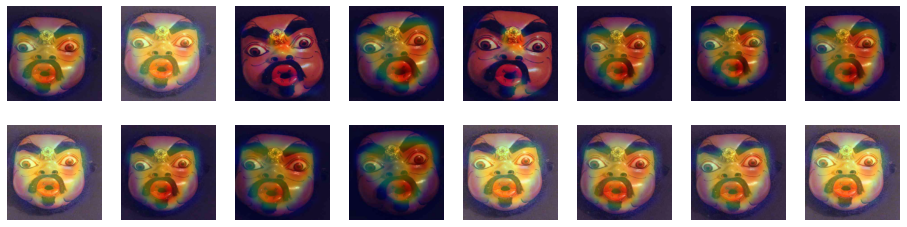


Grad-CAM dalem


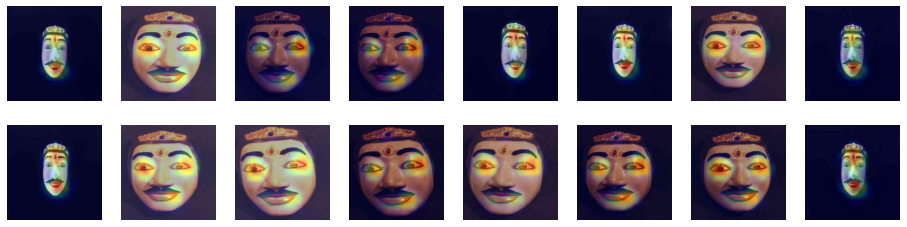


Grad-CAM keras


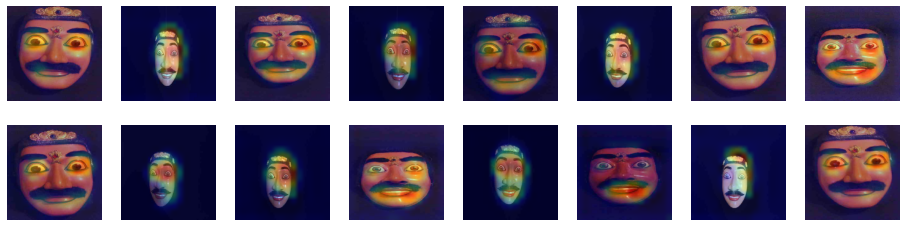


Grad-CAM penasar


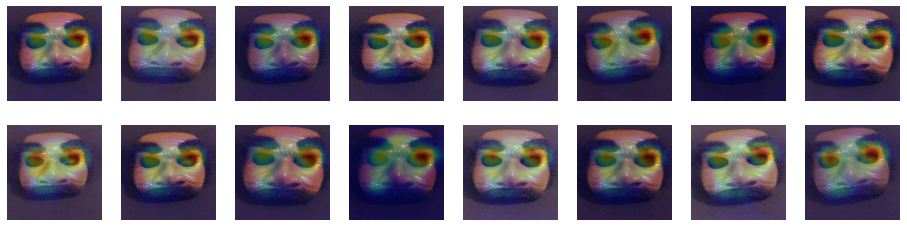


Grad-CAM sidakarya


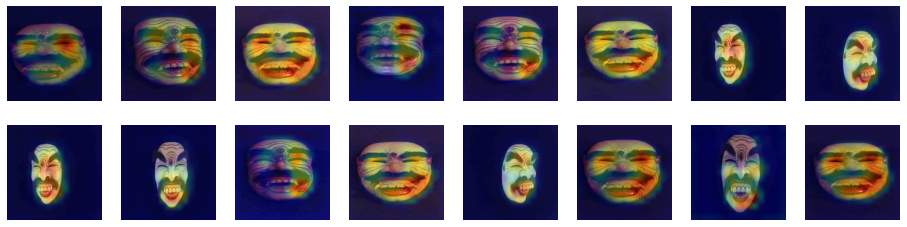


Grad-CAM tua


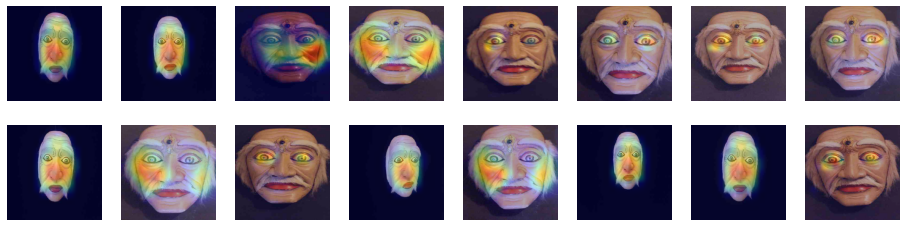


Grad-CAM wijil


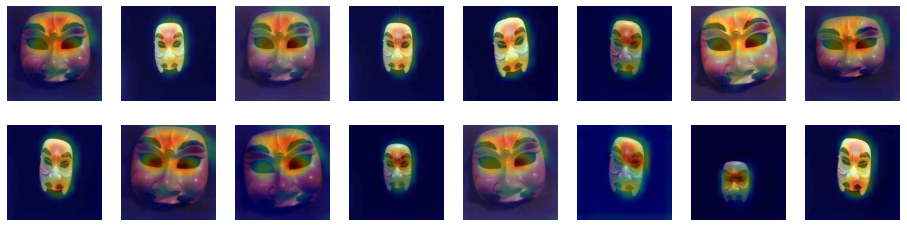

In [40]:
dataset_dir = dataset_dist['train']
wrapper = cnn
ncols = 8
n = ncols*2
figsize = (16,4)
labels = sorted(os.listdir(dataset_dir))

for label in labels: 
    show_gradcam_images_from_model_wrapper(
        dataset_dir=dataset_dir, 
        wrapper=wrapper, 
        ncols=ncols, 
        n=n, 
        figsize=figsize,
        single_label=True,
        custom_label=label,
    )
    print()

## Export Model

### Export to TFJS

In [41]:
if EXPORT_TO_JS:
    os.system('pip install -q tensorflowjs')
    cnn.export_to_tfjs(EXPORT_MODEL_JS_DIR)

### Export TFLite

In [42]:
if EXPORT_TO_TFLITE:
    cnn.export_to_tflite(EXPORT_MODEL_TFLITE_PATH)

### Export to Saved Model

In [43]:
if EXPORT_TO_SAVED_MODEL:
    cnn.saved_model(EXPORT_MODEL_SAVED_DIR)

### Export to H5

In [44]:
if EXPORT_TO_H5:
    cnn.export_to_h5(EXPORT_MODEL_H5)

## Classify Real Data

### Upload Images

In [45]:
if TEST_REAL_DATA:
    cnn.test_upload_images(show_image=False)